In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd

import csv as csv
import sklearn
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm as lgb

from utils import save_to_csv, reduce_memory_usage,custom_kfold_scorer 

In [5]:
train_df = pd.read_csv("./train_2.csv")
test_df = pd.read_csv("./test_2.csv")
aux_df = pd.read_csv("./auxiliary-data/sg-shopping-malls.csv")

In [6]:
aux_df.head()

,name,lat,lng,wikipedia_link
0,100 AM,1.275012,103.841372,NaN
1,313@Somerset,1.301013,103.838540,NaN
2,Aperia,1.309714,103.863837,NaN
3,Balestier Hill Shopping Centre,1.325442,103.842521,NaN
4,Bugis Cube,1.298276,103.855555,NaN


## Check for NULL values

In [7]:
aux_df.isnull().any()

name              False
lat               False
lng               False
wikipedia_link     True
dtype: bool

In [8]:
aux_df['wikipedia_link'].unique()

array([nan, '/wiki/Bugis_Junction', '/wiki/Bugis%2B',
       '/wiki/Capitol_Piazza', '/wiki/Cathay_Cineleisure_Orchard',
       '/wiki/The_CentrePoint', '/wiki/City_Square_Mall',
       '/wiki/CityLink_Mall', '/wiki/DUO', '/wiki/Far_East_Plaza',
       '/wiki/Funan,_Singapore', '/wiki/Great_World_City',
       '/wiki/HDB_Hub', '/wiki/Holland_Village,_Singapore',
       '/wiki/ION_Orchard', '/wiki/Junction_8', '/wiki/Liang_Court',
       '/wiki/Liat_Towers', '/wiki/Lucky_Plaza', '/wiki/Marina_Bay_Sands',
       '/wiki/Marina_Bay_Link_Mall', '/wiki/Marina_One',
       '/wiki/Marina_Square', '/wiki/Millenia_Walk',
       '/wiki/Mustafa_Centre', '/wiki/Ngee_Ann_City',
       '/wiki/Orchard_Central', '/wiki/Orchard_Gateway',
       '/wiki/Palais_Renaissance', '/wiki/People%27s_Park_Centre',
       '/wiki/People%27s_Park_Complex', '/wiki/Plaza_Singapura',
       '/wiki/Raffles_City_Singapore', '/wiki/Shaw_House_and_Centre',
       '/wiki/Sim_Lim_Square', '/wiki/South_Beach,_Singapore',
     

There are some null values in wikipedia_link column. We do not need the wikipedia link column for any analysis so we will drop this column and take care of the NULL values also.

In [9]:
aux_df = aux_df.drop(columns=['wikipedia_link'])

In [10]:
aux_df.isnull().any()

name    False
lat     False
lng     False
dtype: bool

### Checking for duplicate values

In [11]:
aux_df.duplicated().any()

False

### Club latitude and longitude together and drop 'lat' and 'lng' columns

In [12]:
aux_df['lat_long'] = list(zip(aux_df.lat, aux_df.lng))

In [13]:
aux_df.head()

,name,lat,lng,lat_long
0,100 AM,1.275012,103.841372,"(1.2750117, 103.8413716)"
1,313@Somerset,1.301013,103.838540,"(1.3010128, 103.83853994515806)"
2,Aperia,1.309714,103.863837,"(1.3097138000000002, 103.8638367)"
3,Balestier Hill Shopping Centre,1.325442,103.842521,"(1.32544235, 103.84252114874478)"
4,Bugis Cube,1.298276,103.855555,"(1.2982756000000002, 103.8555546)"


## Distribution of HDB flats and Shopping malls

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

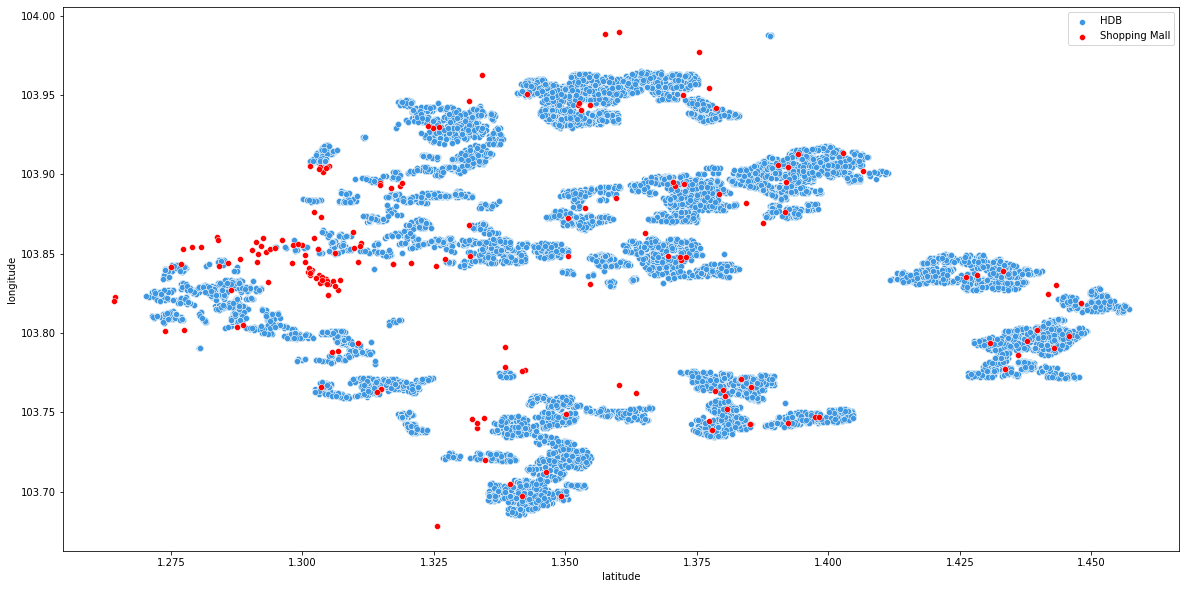

In [14]:
plt.figure(figsize=(20,10))
sns.scatterplot(y=train_df.longitude,x=train_df.latitude,color="#3E97E0",label="HDB")
sns.scatterplot(y=aux_df.lng,x=aux_df.lat,color="red",label="Shopping Mall")

### Extract lat_long and year columns from train and test data sets

In [22]:
train_df_temp = train_df[["lat_long"]]
test_df_temp = test_df[["lat_long"]]

### Drop duplicate locations

In [23]:
train_df_temp = train_df_temp.drop_duplicates(subset=['lat_long'])
test_df_temp = test_df_temp.drop_duplicates(subset=['lat_long'])

### Add columns to store the nearest shopping mall and its distance and number of shopping malls within 0.5km

In [24]:
train_df_temp["nearest_shopping_mall"] = str("--")
train_df_temp["nearest_shopping_mall_distance"] = math.inf
train_df_temp["shopping_mall_half_km"] = 0
test_df_temp["nearest_shopping_mall"] = str("--")
test_df_temp["nearest_shopping_mall_distance"] = math.inf
test_df_temp["shopping_mall_half_km"] = 0
train_df_temp = train_df_temp.reset_index()
test_df_temp = test_df_temp.reset_index()

In [26]:
aux_df.head()

,index,name,lat_long
0,0,100 AM,"(1.2750117, 103.8413716)"
1,1,313@Somerset,"(1.3010128, 103.83853994515806)"
2,2,Aperia,"(1.3097138000000002, 103.8638367)"
3,3,Balestier Hill Shopping Centre,"(1.32544235, 103.84252114874478)"
4,4,Bugis Cube,"(1.2982756000000002, 103.8555546)"


In [27]:
train_df_temp.head()

,index,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,0,"(1.3690080642700195, 103.95869445800781)",--,inf,0
1,1,"(1.3990070819854736, 103.90699005126953)",--,inf,0
2,2,"(1.3883482217788696, 103.87381744384766)",--,inf,0
3,3,"(1.3184930086135864, 103.7667007446289)",--,inf,0
4,4,"(1.3481495380401611, 103.74266052246094)",--,inf,0


In [28]:
test_df_temp.head()

,index,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,0,"(1.3465807437896729, 103.74408721923828)",--,inf,0
1,1,"(1.3576176166534424, 103.96138000488281)",--,inf,0
2,2,"(1.337803840637207, 103.74199676513672)",--,inf,0
3,3,"(1.380083680152893, 103.84957122802734)",--,inf,0
4,4,"(1.3139597177505493, 103.76982879638672)",--,inf,0


Converting our dataframe to numpy arrays for faster computation

In [29]:
train_df_temp_numpy = train_df_temp.to_numpy()
test_df_temp_numpy = test_df_temp.to_numpy()
aux_df_numpy = aux_df.to_numpy()

In [30]:
print("Shape of train_df_temp_numpy :",np.shape(train_df_temp_numpy))
print("Shape of test_df_temp_numpy :",np.shape(test_df_temp_numpy))
print("Shape of aux_df_numpy :",np.shape(aux_df_numpy))

Shape of train_df_temp_numpy : (9138, 5)
Shape of test_df_temp_numpy : (8990, 5)
Shape of aux_df_numpy : (174, 3)


## Get the nearest shopping mall and its distance from HDB. Also count the number of shopping mall within 0.5km from HDB

In [31]:
%%time
print("Get distance for each location and update nearest shopping mall and its distance")
for i in range(len(train_df_temp_numpy)):
    min_dist = math.inf
    min_dist_aux = ""
    hdb_location = train_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    count = 0
    for j in range(len(aux_df_numpy)):
        aux_location = aux_df_numpy[j][2]
        distance = geopy.distance.great_circle(hdb_location, aux_location).km
        if distance < min_dist:
            min_dist = distance
            min_dist_mrt = aux_df_numpy[j][1]
        if distance <= 1:
            count+=1
    train_df_temp_numpy[i][2] = min_dist_mrt
    train_df_temp_numpy[i][3] = min_dist
    train_df_temp_numpy[i][4] = count

print("Add nearest_shopping_mall and nearest_shopping_mall_distance and count of shopping malls in half km to dataframe")
for i in range(len(train_df_temp_numpy)):
    dataframe_index = train_df_temp_numpy[i][0]
    train_df_temp.loc[i, "nearest_shopping_mall"] = train_df_temp_numpy[i][2]
    train_df_temp.loc[i, "nearest_shopping_mall_distance"] = train_df_temp_numpy[i][3]
    train_df_temp.loc[i, "shopping_mall_half_km"] = train_df_temp_numpy[i][4]

Get distance for each location and update nearest shopping mall and its distance
Add nearest_shopping_mall and nearest_shopping_mall_distance and count of shopping malls in half km to dataframe
Wall time: 23 s


In [32]:
%%time
print("Get distance for each location and update nearest shopping mall and its distance")
for i in range(len(test_df_temp_numpy)):
    min_dist = math.inf
    min_dist_aux = ""
    hdb_location = test_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    count = 0
    for j in range(len(aux_df_numpy)):
        aux_location = aux_df_numpy[j][2]
        distance = geopy.distance.great_circle(hdb_location, aux_location).km
        if distance < min_dist:
            min_dist = distance
            min_dist_mrt = aux_df_numpy[j][1]
        if distance <= 0.5:
            count+=1
    test_df_temp_numpy[i][2] = min_dist_mrt
    test_df_temp_numpy[i][3] = min_dist
    test_df_temp_numpy[i][4] = count

print("Add nearest_shopping_mall and nearest_shopping_mall_distance and count of shopping malls in half km to dataframe")
for i in range(len(test_df_temp_numpy)):
    dataframe_index = test_df_temp_numpy[i][0]
    test_df_temp.loc[i, "nearest_shopping_mall"] = test_df_temp_numpy[i][2]
    test_df_temp.loc[i, "nearest_shopping_mall_distance"] = test_df_temp_numpy[i][3]
    test_df_temp.loc[i, "shopping_mall_half_km"] = test_df_temp_numpy[i][4]

Get distance for each location and update nearest shopping mall and its distance
Add nearest_shopping_mall and nearest_shopping_mall_distance and count of shopping malls in half km to dataframe
Wall time: 22.5 s


In [33]:
train_df_temp.head()

,index,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,0,"(1.3690080642700195, 103.95869445800781)",Downtown East,1.033117,0
1,1,"(1.3990070819854736, 103.90699005126953)",Rivervale Mall,0.806018,4
2,2,"(1.3883482217788696, 103.87381744384766)",The Seletar Mall,0.452401,2
3,3,"(1.3184930086135864, 103.7667007446289)",321 Clementi,0.456448,3
4,4,"(1.3481495380401611, 103.74266052246094)",West Mall,0.763916,1


In [34]:
test_df_temp.head()

,index,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,0,"(1.3465807437896729, 103.74408721923828)",West Mall,0.693774,0
1,1,"(1.3576176166534424, 103.96138000488281)",Tampines Mall,1.934091,0
2,2,"(1.337803840637207, 103.74199676513672)",Jem,0.524649,0
3,3,"(1.380083680152893, 103.84957122802734)",Djitsun Mall,0.829051,0
4,4,"(1.3139597177505493, 103.76982879638672)",321 Clementi,0.604384,0


### We will now merge the result with our original data frames

In [35]:
temp = train_df_temp[["lat_long", "nearest_shopping_mall", "nearest_shopping_mall_distance","shopping_mall_half_km"]]
train_df = pd.merge(train_df, temp, on="lat_long", how='left')

temp = test_df_temp[["lat_long", "nearest_shopping_mall", "nearest_shopping_mall_distance","shopping_mall_half_km"]]
test_df = pd.merge(test_df, temp, on="lat_long", how='left')

### Nearest Shopping Mall and its distance from HDB has been added to our dataframe

In [36]:
train_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,resale_price,month_no,year,storey,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,pasir ris,4-room,440,pasir ris drive 4,118.0,model a,1989,1.369008,103.958694,pasir ris drive,pasir ris,east region,209700.0,8,2001,2.0,"(1.3690080642700195, 103.95869445800781)",Downtown East,1.033117,0
1,punggol,5-room,196B,punggol field,110.0,improved,2003,1.399007,103.906990,punggol field,punggol,north-east region,402300.0,10,2014,11.0,"(1.3990070819854736, 103.90699005126953)",Rivervale Mall,0.806018,4
2,sengkang,5-room,404A,fernvale lane,112.0,premium apartment,2004,1.388348,103.873820,fernvale,sengkang,north-east region,351000.0,9,2020,2.0,"(1.3883482217788696, 103.87381744384766)",The Seletar Mall,0.452401,2
3,clementi,3-room,375,clementi avenue 4,67.0,new generation,1980,1.318493,103.766700,clementi north,clementi,west region,151200.0,10,2000,8.0,"(1.3184930086135864, 103.7667007446289)",321 Clementi,0.456448,3
4,bukit batok,3-room,163,bukit batok street 11,73.0,model a,1985,1.348150,103.742660,bukit batok west,bukit batok,west region,318600.0,1,2013,8.0,"(1.3481495380401611, 103.74266052246094)",West Mall,0.763916,1


In [37]:
test_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,month_no,year,storey,lat_long,nearest_shopping_mall,nearest_shopping_mall_distance,shopping_mall_half_km
0,bukit batok,4-room,186,bukit batok west avenue 6,94.0,new generation,1989,1.346581,103.74409,bukit batok west,bukit batok,west region,1,2004,5.0,"(1.3465807437896729, 103.74408721923828)",West Mall,0.693774,0
1,tampines,5-room,366,tampines street 34,122.0,improved,1997,1.357618,103.96138,tampines east,tampines,east region,11,2001,5.0,"(1.3576176166534424, 103.96138000488281)",Tampines Mall,1.934091,0
2,jurong east,3-room,206,jurong east street 21,67.0,new generation,1982,1.337804,103.74200,toh guan,jurong east,west region,7,2002,2.0,"(1.337803840637207, 103.74199676513672)",Jem,0.524649,0
3,ang mo kio,3-room,180,Ang Mo Kio Avenue 5,82.0,new generation,1981,1.380084,103.84957,yio chu kang east,ang mo kio,north-east region,4,2015,5.0,"(1.380083680152893, 103.84957122802734)",Djitsun Mall,0.829051,0
4,clementi,5-room,356,clementi avenue 2,117.0,standard,1978,1.313960,103.76983,clementi north,clementi,west region,4,2004,2.0,"(1.3139597177505493, 103.76982879638672)",321 Clementi,0.604384,0


# Correlation between shopping mall and resale_price

<AxesSubplot:>

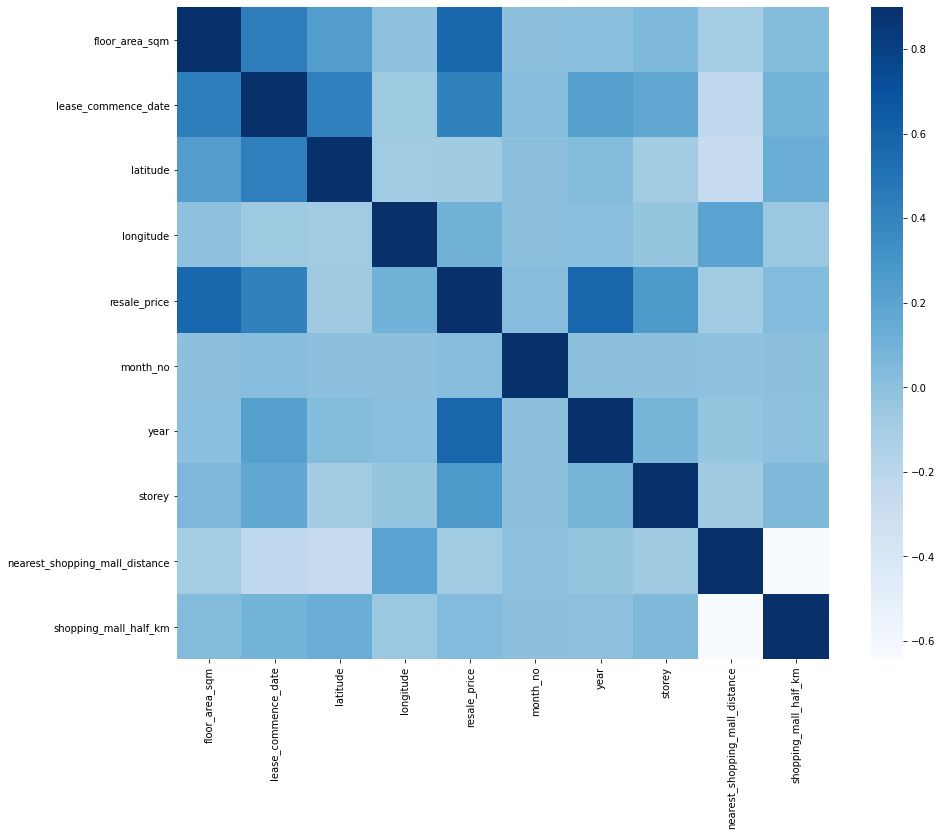

In [38]:
corr = train_df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [40]:
corr[['resale_price']].sort_values(by='resale_price',ascending=False)[6:7].style.background_gradient(cmap='viridis', axis=None)

,resale_price
shopping_mall_half_km,0.039269


In [41]:
corr[['resale_price']].sort_values(by='resale_price',ascending=False)[9:].style.background_gradient(cmap='viridis', axis=None)

,resale_price
nearest_shopping_mall_distance,-0.074991


### Reduce the size of dataframe to save memory during training

In [42]:
train_df, _ = reduce_memory_usage(train_df)
test_df, _ = reduce_memory_usage(test_df)

Memory usage of properties dataframe is : 69.17092895507812  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  47.34914779663086  MB
This is  68.45238095238095 % of the initial size
Memory usage of properties dataframe is : 16.46942138671875  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  11.425661087036133  MB
This is  69.375 % of the initial size


### Segregate the columns

In [43]:
integer_columns = [
    "lease_commence_date",
    "storey",
    "month_no",
    "year",
    "nearest_shopping_mall_distance",
    "shopping_mall_half_km"
]

float_columns = [
    "floor_area_sqm",
]

target_column = [
    "resale_price"
]

## Categorical columns need to be encoded before training
categorical_columns = [
    "town",
    "flat_type",
    "flat_model",
    "subzone",
    "planning_area",
    "region"
]

## We will drop these columns before training
drop_columns = [
    "lat_long",
    "block",
    "street_name",
    "nearest_shopping_mall",
    "latitude",
    "longitude"
]

### Drop the selected columns

In [44]:
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

In [45]:
train_df.head()

,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,resale_price,month_no,year,storey,nearest_shopping_mall_distance,shopping_mall_half_km
0,pasir ris,4-room,118.0,model a,1989,pasir ris drive,pasir ris,east region,209700.0,8,2001,2,1.033117,0
1,punggol,5-room,110.0,improved,2003,punggol field,punggol,north-east region,402300.0,10,2014,11,0.806018,4
2,sengkang,5-room,112.0,premium apartment,2004,fernvale,sengkang,north-east region,351000.0,9,2020,2,0.452401,2
3,clementi,3-room,67.0,new generation,1980,clementi north,clementi,west region,151200.0,10,2000,8,0.456448,3
4,bukit batok,3-room,73.0,model a,1985,bukit batok west,bukit batok,west region,318600.0,1,2013,8,0.763916,1


In [46]:
test_df.head()

,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,month_no,year,storey,nearest_shopping_mall_distance,shopping_mall_half_km
0,bukit batok,4-room,94.0,new generation,1989,bukit batok west,bukit batok,west region,1,2004,5,0.693774,0
1,tampines,5-room,122.0,improved,1997,tampines east,tampines,east region,11,2001,5,1.934091,0
2,jurong east,3-room,67.0,new generation,1982,toh guan,jurong east,west region,7,2002,2,0.524648,0
3,ang mo kio,3-room,82.0,new generation,1981,yio chu kang east,ang mo kio,north-east region,4,2015,5,0.829051,0
4,clementi,5-room,117.0,standard,1978,clementi north,clementi,west region,4,2004,2,0.604384,0


### One hot encode categorical columns

In [47]:
for col in categorical_columns:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[col], prefix=col)],axis=1)
train_df = train_df.drop(columns=categorical_columns)

for col in categorical_columns:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[col], prefix=col)],axis=1)
test_df = test_df.drop(columns=categorical_columns)

### Check if the columns in both test data and train data are same after one-hot encoding

In [48]:
columns_in_test_not_in_train = test_df.columns.difference(train_df.columns).tolist()
#print(columns_in_test_not_in_train)
columns_in_train_not_in_test = train_df.columns.difference((test_df.columns)).tolist()
columns_in_train_not_in_test.remove('resale_price')
#print(columns_in_train_not_in_test)
if not columns_in_test_not_in_train and not columns_in_train_not_in_test:
    print("Columns are same")

Columns are same


### Split training data into training and validation sets

In [49]:
train_data = train_df.sample(frac=1)
train_labels = train_data.pop('resale_price')
train_x, val_x, train_y, val_y = train_test_split(train_data,train_labels,train_size=0.8)

--------

## Decision Tree

#### Train model using default hyperparameters

In [50]:
dt_1 = tree.DecisionTreeRegressor()

In [51]:
%%time
dt_1 = dt_1.fit(train_x, train_y)

Wall time: 10.8 s


In [52]:
train_prediction = dt_1.predict(train_x)
val_prediction = dt_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 1496.010428315706
Validation error(RMSE) : 25507.45190859495
R2 score for training data : 0.9998671847717084
R2 score for validation data : 0.9615399056182559


#### Modify max_depth and min_samples_split and try next model

In [53]:
dt_2 = tree.DecisionTreeRegressor(max_depth=30,min_samples_split=30)

In [54]:
%%time
dt_2 = dt_2.fit(train_x, train_y)

Wall time: 9.29 s


In [55]:
train_prediction = dt_2.predict(train_x)
val_prediction = dt_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 17410.710538977444
Validation error(RMSE) : 22708.27431031356
R2 score for training data : 0.9820108094621666
R2 score for validation data : 0.9695179299943982


#### Modify max_depth and min_samples_split and try next model

In [56]:
dt_3 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=15)
dt_3 = dt_3.fit(train_x, train_y)

In [57]:
train_prediction = dt_3.predict(train_x)
val_prediction = dt_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 13988.223582941828
Validation error(RMSE) : 22831.121717828188
R2 score for training data : 0.9883880873044107
R2 score for validation data : 0.9691872336036976


#### Modify max_depth and min_samples_split and try next model

In [58]:
dt_4 = tree.DecisionTreeRegressor(max_depth=300,min_samples_split=30)

In [59]:
%%time
dt_4 = dt_4.fit(train_x, train_y)

Wall time: 10.3 s


In [60]:
train_prediction = dt_4.predict(train_x)
val_prediction = dt_4.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 17146.710567929746
Validation error(RMSE) : 22661.08746377182
R2 score for training data : 0.9825522164237503
R2 score for validation data : 0.969644479314834


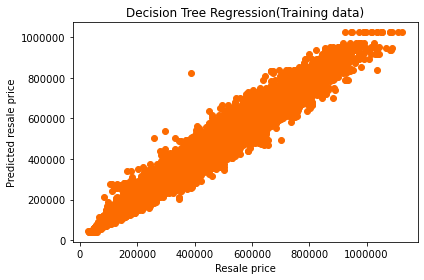

In [61]:
#plt.figure(figsize=(10,8))
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
#plt.scatter(val_prediction, val_y, color = 'green')
plt.title('Decision Tree Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./dt_4_sm_training_data.tiff",dpi=300)
plt.show()

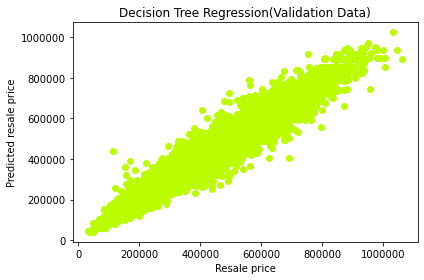

In [62]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('Decision Tree Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./dt_4_sm_validation_data.tiff",dpi=300)
plt.show()

In [63]:
dt_4_feature_importance = pd.DataFrame({'Feature':train_x.columns,'Importance':dt_4.feature_importances_}).sort_values('Importance', ascending=False)

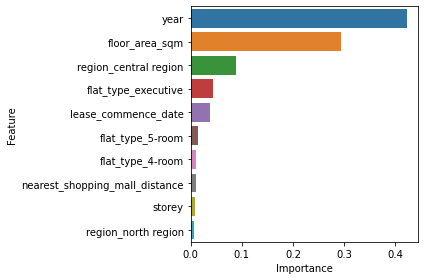

In [64]:
sns.barplot(y='Feature', x='Importance', data=dt_4_feature_importance.head(10))
plt.tight_layout()
plt.savefig("./dt_4_sm_feature_importance.tiff",dpi=300)

#### Uncomment next block to make prediction on test data and generate csv

In [93]:
test_result = dt_3.predict(test_df)
save_to_csv(test_result,"./shopping_mall_dt_3_result.csv")

-----------

## Random Forest

#### Train model using default hyperparameters

In [94]:
rf_1 = RandomForestRegressor()

In [95]:
%%time
rf_1.fit(train_x,train_y)

Wall time: 11min 17s


RandomForestRegressor()

In [96]:
train_prediction = rf_1.predict(train_x)
val_prediction = rf_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 7017.488714886078
Validation error(RMSE) : 18333.321031610783
R2 score for training data : 0.9970812909972416
R2 score for validation data : 0.9800312693497623


#### Modify max_depth and n_estimators and try next model

In [65]:
rf_2 = RandomForestRegressor(n_estimators=50,max_depth=10,n_jobs=-1,verbose=1)

In [66]:

%%time
rf_2.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min


Wall time: 2min 16s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, verbose=1)

In [67]:
train_prediction = rf_2.predict(train_x)
val_prediction = rf_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Training error(RMSE) : 34469.82769010207
Validation error(RMSE) : 34807.81756315744
R2 score for training data : 0.9294890028877781
R2 score for validation data : 0.9283807480248345


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


#### Modify max_depth and n_estimators and try next model

In [68]:
rf_3 = RandomForestRegressor(n_estimators=50,max_depth=50,n_jobs=-1,verbose=1)

In [69]:
%%time
rf_3.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min


Wall time: 2min 55s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished


RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=-1, verbose=1)

In [70]:
train_prediction = rf_3.predict(train_x)
val_prediction = rf_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


Training error(RMSE) : 7154.300266359387
Validation error(RMSE) : 18567.024619710523
R2 score for training data : 0.9969625232775627
R2 score for validation data : 0.9796220346609402


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished


#### Modify max_depth, n_estimators and max_features and try next model

In [71]:
rf_4 = RandomForestRegressor(n_estimators=50,max_depth=50,max_features=50,n_jobs=-1,verbose=1)

In [72]:
%%time
rf_4.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.6s


Wall time: 53.7 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   53.4s finished


RandomForestRegressor(max_depth=50, max_features=50, n_estimators=50, n_jobs=-1,
                      verbose=1)

In [73]:

train_prediction = rf_4.predict(train_x)
val_prediction = rf_4.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished


Training error(RMSE) : 7309.525143568032
Validation error(RMSE) : 18705.823420100165
R2 score for training data : 0.9968292868047138
R2 score for validation data : 0.979316222688447


In [74]:
feature_importance_rf_4 = pd.DataFrame({'Feature':train_x.columns,'Importance':rf_4.feature_importances_}).sort_values('Importance', ascending=False)

In [75]:
feature_importance_rf_4.head(10)

,Feature,Importance
3,year,0.370196
0,floor_area_sqm,0.171474
1,lease_commence_date,0.062551
35,flat_type_3-room,0.051506
247,region_central region,0.049359
38,flat_type_executive,0.029969
37,flat_type_5-room,0.029452
4,storey,0.028057
36,flat_type_4-room,0.027198
46,flat_model_maisonette,0.013427


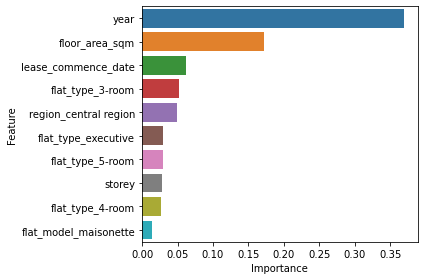

In [76]:
sns.barplot(y='Feature', x='Importance', data=feature_importance_rf_4.head(10))
plt.tight_layout()
plt.savefig("./rf_4_sm_feature_importance.tiff",dpi=300)

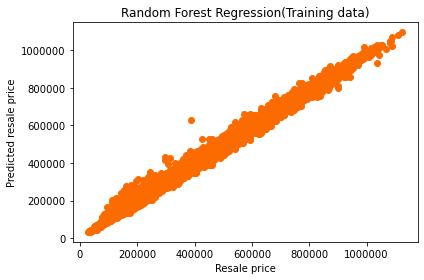

In [77]:
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
plt.title('Random Forest Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./rf_4_sm_training_data.tiff",dpi=300)
plt.show()

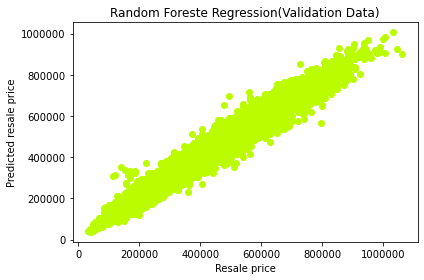

In [78]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('Random Foreste Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./rf_4_sm_validation_data.tiff",dpi=300)
plt.show()

#### Uncomment next block to make prediction on test data and generate csv

In [97]:
test_result = rf_1.predict(test_df)
save_to_csv(test_result,"./shopping_mall_rf_1_result.csv")

--------

## XGBOOST

#### Train model using default hyperparameters

In [98]:
xgb_model_1 = xgboost.XGBRegressor()

In [99]:
%%time
xgb_model_1.fit(train_x,train_y)

Wall time: 51.4 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [100]:
train_prediction = xgb_model_1.predict(train_x)
val_prediction = xgb_model_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 20924.15
Validation error(RMSE) : 21390.357
R2 score for training data : 0.9740508610053606
R2 score for validation data : 0.972816568799326


#### Modify hyperparameters and try next model

In [79]:
xgb_model_2 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=50,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [80]:
%%time
xgb_model_2.fit(train_x,train_y)

Wall time: 3min 40s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=50,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [81]:
train_prediction = xgb_model_2.predict(train_x)
val_prediction = xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11802.878
Validation error(RMSE) : 22242.78
R2 score for training data : 0.9917328774666534
R2 score for validation data : 0.9707548194093548


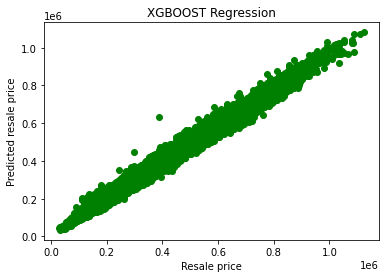

In [82]:
plt.scatter(train_y,train_prediction, color = 'green')
plt.title('XGBOOST Regression')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.show()

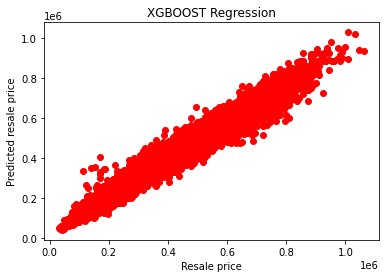

In [83]:
plt.scatter(val_y,val_prediction, color = 'red')
plt.title('XGBOOST Regression')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.show()

#### Uncomment next block to make prediction on test data and generate csv

In [105]:
#test_result = xgb_model_2.predict(test_df)
#save_to_csv(test_result,"./shopping_mall_xgb_model_2_result.csv")

-------

## LightGBM

#### Train model using default hyperparameters

In [112]:
gbm_1 = lgb.LGBMRegressor()

In [113]:
%%time
gbm_1 = gbm_1.fit(train_x,train_y)

Wall time: 1.99 s


In [114]:
train_prediction = gbm_1.predict(train_x)
val_prediction = gbm_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 24033.514191170998
Validation error(RMSE) : 24142.73424309927
R2 score for training data : 0.9657656640449436
R2 score for validation data : 0.9653709099362023


#### Modify learning_rate, max_depth and n_estimators and try next model

In [84]:
gbm_2 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=10000,n_estimators=10000)

In [85]:
%%time
gbm_2 = gbm_2.fit(train_x,train_y)

Wall time: 40 s


In [86]:
train_prediction = gbm_2.predict(train_x)
val_prediction = gbm_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11881.179585892372
Validation error(RMSE) : 16284.942846841881
R2 score for training data : 0.9916228218358666
R2 score for validation data : 0.9843235157639247


In [87]:
feature_importance_gbm_2 = pd.DataFrame({'Feature':train_x.columns,'Importance':gbm_2.feature_importances_}).sort_values('Importance', ascending=False)

In [88]:
feature_importance_gbm_2.head(10)

,Feature,Importance
3,year,65344
5,nearest_shopping_mall_distance,51303
0,floor_area_sqm,43353
2,month_no,37342
4,storey,27346
1,lease_commence_date,19369
6,shopping_mall_half_km,6208
36,flat_type_4-room,2274
44,flat_model_improved,2084
47,flat_model_model a,1960


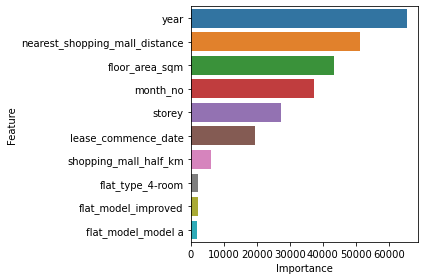

In [89]:
sns.barplot(y='Feature', x='Importance', data=feature_importance_gbm_2.head(10))
plt.tight_layout()
plt.savefig("./gbm_2_sm_feature_importance.tiff",dpi=300)

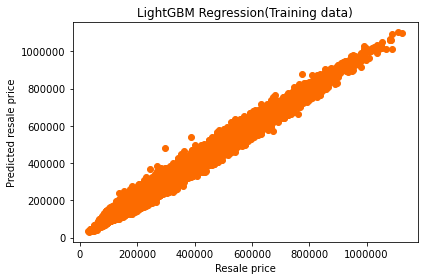

In [90]:

#plt.figure(figsize=(10,8))
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
#plt.scatter(val_prediction, val_y, color = 'green')
plt.title('LightGBM Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./gbm_2_sm_training_data.tiff",dpi=300)
plt.show()

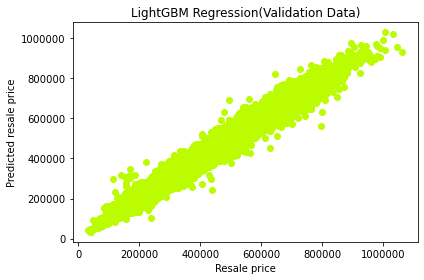

In [91]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('LightGBM Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./gbm_2_sm_validation_data.tiff",dpi=300)
plt.show()

#### Modify learning_rate, max_depth and n_estimators and try next model

In [94]:
gbm_3 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=5000,n_estimators=5000)

In [95]:
%%time
gbm_3.fit(
    train_x, train_y, 
    eval_set= [(train_x, train_y), (val_x, val_y)], 
    eval_metric='rmse', verbose=1000)

[1000]	training's rmse: 16786.3	training's l2: 2.8178e+08	valid_1's rmse: 17693.7	valid_1's l2: 3.13068e+08
[2000]	training's rmse: 15367	training's l2: 2.36144e+08	valid_1's rmse: 16871.4	valid_1's l2: 2.84645e+08
[3000]	training's rmse: 14552.7	training's l2: 2.11781e+08	valid_1's rmse: 16576.9	valid_1's l2: 2.74794e+08
[4000]	training's rmse: 13963.1	training's l2: 1.94967e+08	valid_1's rmse: 16420.2	valid_1's l2: 2.69625e+08
[5000]	training's rmse: 13481.2	training's l2: 1.81741e+08	valid_1's rmse: 16335.1	valid_1's l2: 2.66837e+08
Wall time: 32 s


LGBMRegressor(max_depth=5000, n_estimators=5000)

In [96]:
train_prediction = gbm_3.predict(train_x)
val_prediction = gbm_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 13481.130454523229
Validation error(RMSE) : 16335.144487298494
R2 score for training data : 0.9892147242346006
R2 score for validation data : 0.9842267149027277


#### Uncomment next block to make prediction on test data and generate csv

In [118]:
#test_result = gbm_2.predict(test_df)
#save_to_csv(test_result,"./shopping_mall_gbm_2_result.csv")

--------------

## Prediction using Random Forest, XGBOOST and LightGBM together

In [119]:
train_prediction = 0.4*gbm_2.predict(train_x) + 0.4*rf_1.predict(train_x) +0.2*xgb_model_2.predict(train_x)
val_prediction = 0.4*gbm_2.predict(val_x)+ 0.4*rf_1.predict(val_x) +0.2*xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 9005.78728432648
Validation error(RMSE) : 16571.46212826635
R2 score for training data : 0.9951930376406986
R2 score for validation data : 0.9836848966364977


#### Uncomment next block to make prediction on test data and generate csv

In [120]:
test_result = 0.4*gbm_2.predict(test_df) + 0.4*rf_1.predict(test_df) +0.2*xgb_model_2.predict(test_df)
save_to_csv(test_result,"./shopping_mall_gbm_2_xgb_model_2_rf_1_result.csv")